# KNN算法

## 概述
-   k-近邻（kNN, k-NearestNeighbor）算法是一种基本分类与回归方法，我们这里只讨论分类问题中的 k-近邻算法。
-   k 近邻算法的输入为实例的特征向量，对应于特征空间的点；输出为实例的类别，可以取多类。k 近邻算法假设给定一个训练数据集，其中的实例类别已定。分类时，对新的实例，根据其 k 个最近邻的训练实例的类别，通过多数表决等方式进行预测。因此，k近邻算法不具有显式的学习过程。
-   k 近邻算法实际上利用训练数据集对特征向量空间进行划分，并作为其分类的“模型”。 k值的选择、距离度量以及分类决策规则是k近邻算法的三个基本要素。

## 工作原理
1.  假设有一个带有标签的样本数据集（训练样本集），其中包含每条数据与所属分类的对应关系。
2.  输入没有标签的新数据后，将新数据的每个特征与样本集中数据对应的特征进行比较。
    -   计算新数据与样本数据集中每条数据的距离。
    -   对求得的所有距离进行排序（从小到大，越小表示越相似）。
    -   取前 k （k 一般小于等于 20 ）个样本数据对应的分类标签。
3.  求 k 个数据中出现次数最多的分类标签作为新数据的分类。

## 算法特点
-   优点: 精度高、对异常值不敏感、无数据输入假定
-   缺点: 计算复杂度高、空间复杂度高
-   适用数据范围: 数值型和标称型

# 实战项目
## 概述
海伦使用约会网站寻找约会对象。经过一段时间之后，她发现曾交往过三种类型的人:
-   不喜欢的人
-   魅力一般的人
-   极具魅力的人
她希望:
-   工作日与魅力一般的人约会
-   周末与极具魅力的人约会
-   不喜欢的人则直接排除掉
现在她收集到了一些约会网站未曾记录的数据信息，这更有助于匹配对象的归类。
海伦把这些约会对象的数据存放在文本文件 datingTestSet2.txt 中，总共有 1000 行。海伦约会的对象主要包含以下 3 种特征:
-   每年获得的飞行常客里程数
-   玩视频游戏所耗时间百分比
-   每周消费的冰淇淋公升数

In [1]:
import numpy as np
from matplotlib import pyplot as plt

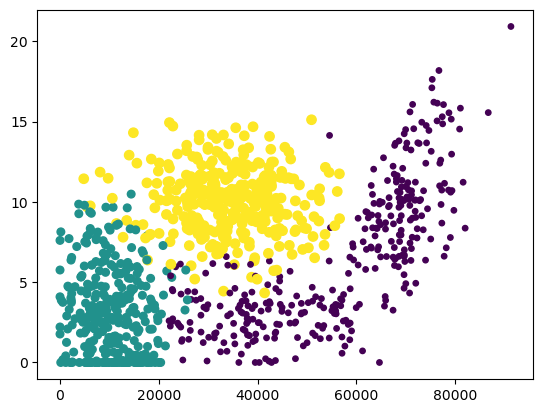

In [2]:
def file2matrix(filename):
    # 不管是readlines还是readline，都会移动文件指针，所以要重新打开文件
    # 获得行数
    fp = open(filename)
    numLines = len(fp.readlines())
    # 获得列数
    fp = open(filename)
    numColumns = len(fp.readline().split('\t')) - 1

    mat = np.zeros((numLines, numColumns))
    labels = []

    fp = open(filename)
    for i, line in enumerate(fp.readlines()):
        data = line.strip().split('\t')
        mat[i, :] = data[:3]
        labels.append(int(data[-1]))

    return mat, labels

def plot_data(mat, labels):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # scatter(x, y, size, color)
    ax.scatter(mat[:, 0], mat[:, 1], 15.0*np.array(labels), 15.0*np.array(labels))
    plt.show()

mat, labels = file2matrix('datingTestSet2.txt')
plot_data(mat, labels)

## 归一化
归一化特征值，消除特征之间量级不同导致的影响
-   为了之后更方便地处理数据
-   程序运行时收敛加快

在统计学中，归一化的具体作用是归纳统一样本的统计分布性。归一化在0-1之间是统计的概率分布，归一化在-1--+1之间是统计的坐标分布。

### 转换方式
1.  线性函数转换
    -   $y=(x-MinValue)/(MaxValue-MinValue)$
2.  对数函数转换
    -   $y=log_{10}(x)


In [3]:
def autoNorm(dataSet):
    # 0表示按第一个轴列取最小值，也就是取列的最小值
    minVals = dataSet.min(0)
    maxVals = dataSet.max(0)
    ranges = maxVals - minVals
    normDataSet = np.zeros(dataSet.shape)
    # 广播
    normDataSet = dataSet - minVals
    normDataSet = normDataSet / ranges

    return normDataSet

normDataSet = autoNorm(mat)
print(normDataSet)

[[0.44832535 0.39805139 0.56233353]
 [0.15873259 0.34195467 0.98724416]
 [0.28542943 0.06892523 0.47449629]
 ...
 [0.29115949 0.50910294 0.51079493]
 [0.52711097 0.43665451 0.4290048 ]
 [0.47940793 0.3768091  0.78571804]]


## 分类
算法伪代码：对于每一个在数据集中的数据点: 
-   计算目标的数据点（需要分类的数据点）与该数据点的距离
-   将距离排序: 从小到大
-   选取前K个最短距离
-   选取这K个中最多的分类类别
-   返回该类别来作为目标数据点的预测值


In [4]:
def classify(X, dataSet, labels, k):
    '''
    X: 待分类的数据
    dataSet: 已知的数据
    labels: 已知数据的标签
    k: k个最近邻
    '''

    # 计算欧式距离
    m = dataSet.shape[0]
    diffMat = X - dataSet
    sqDiffMat = diffMat ** 2
    sqDistances = sqDiffMat.sum(axis=1)
    distances = sqDistances ** 0.5

    # 排序
    sortedDistIndices = distances.argsort()

    # 统计k个最近邻的标签
    classCount = {}
    for i in range(k):
        label = labels[sortedDistIndices[i]]
        classCount[label] = classCount.get(label, 0) + 1
    
    maxKey = max(classCount, key=classCount.get)
    return maxKey
    

## 测试


In [5]:
def datingClassTest():
    # 测试集比例
    hoRatio = 0.1
    datingDataMat, datingLabels = file2matrix('D:/Tools/OneDrive/Code/VsCode/Py_Work/Machine_Learning/1/Chapter2/datingTestSet2.txt')
    normMat = autoNorm(datingDataMat)
    m = normMat.shape[0]
    numTestVecs = int(m * hoRatio)
    print('numTestVecs=', numTestVecs)
    errorCount = 0
    for i in range(numTestVecs):
        
        result = classify(normMat[i, :], normMat[numTestVecs:m, :], datingLabels[numTestVecs:m], 3)
        print(f"the classifier came back with: {result}, the real answer is: {datingLabels[i]}")
        if result != datingLabels[i]:
            errorCount += 1
    print(f"the total error rate is: {errorCount/numTestVecs}")

datingClassTest()

numTestVecs= 100
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 2, the real answer is: 2
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 2, the real answer is: 2
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 

# 实战项目2：手写数字识别

## 概述
构造一个能识别数字 0 到 9 的基于 KNN 分类器的手写数字识别系统。
需要识别的数字是存储在文本文件中的具有相同的色彩和大小: 宽高是 32 像素 * 32 像素的黑白图像。

## 图像数据转换为向量

In [6]:
def img2vector(filename):
    returnVec = np.zeros((1, 32 * 32))
    fp = open(filename)
    for i in range(32):
        lineStr = fp.readline()
        for j in range(32):
            returnVec[0, 32*i+j] = int(lineStr[j])
    return returnVec

## 测试

In [7]:
from os import listdir

def handwritingClassTest():
    # 1. 导入训练数据
    hwLabels = []
    traingingFileList = listdir('D:\\Tools\\OneDrive\\Code\\VsCode\\Py_Work\\Machine_Learning\\1\\Chapter2\\2.KNN\\2.KNN\\trainingDigits')
    m = len(traingingFileList)
    trainingMat = np.zeros((m, 1024))
    # hwLabels存储0-9对应的index, trainingMat存放的每个文件的1x1024图像
    for i in range(m):
        fileNameStr = traingingFileList[i]
        fileStr = fileNameStr.split('.')[0]
        classNumStr = int(fileStr.split('_')[0])
        hwLabels.append(classNumStr)
        trainingMat[i, :] = img2vector('D:\\Tools\\OneDrive\\Code\\VsCode\\Py_Work\\Machine_Learning\\1\\Chapter2\\2.KNN\\2.KNN\\trainingDigits/%s' % fileNameStr)

    # 2. 导入测试数据
    testFileList = listdir('D:\\Tools\\OneDrive\\Code\\VsCode\\Py_Work\\Machine_Learning\\1\\Chapter2\\2.KNN\\2.KNN\\testDigits')
    errorCount = 0
    mTest = len(testFileList)
    for i in range(mTest):
        fileNameStr = testFileList[i]
        fileStr = fileNameStr.split('.')[0]
        classNumStr = int(fileStr.split('_')[0])
        vectorUnderTest = img2vector('D:\\Tools\\OneDrive\\Code\\VsCode\\Py_Work\\Machine_Learning\\1\\Chapter2\\2.KNN\\2.KNN\\testDigits/%s' % fileNameStr)
        classifierResult = classify(vectorUnderTest, trainingMat, hwLabels, 3)
        print(f"the classifier came back with: {classifierResult}, the real answer is: {classNumStr}")
        if classifierResult != classNumStr:
            errorCount += 1
    print(f"\nthe total number of errors is: {errorCount}")
    print(f"\nthe total error rate is: {errorCount/mTest}")

handwritingClassTest()

the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answe

# 总结

## KNN是什么
KNN 是一个简单的无显式学习过程，非泛化学习的监督学习模型。在分类和回归中均有应用。

## 基本原理
通过距离度量来计算查询点（query point）与每个训练数据点的距离，然后选出与查询点（query point）相近的K个最邻点（K nearest neighbors），使用分类决策来选出对应的标签来作为该查询点的标签。

## KNN三要素
### K的取值
对查询点标签影响显著（效果拔群）。k值小的时候 近似误差小，估计误差大。 k值大 近似误差大，估计误差小。
-   如果选择较小的 k 值，就相当于用较小的邻域中的训练实例进行预测
    -   “学习”的近似误差（approximation error）会减小，只有与输入实例较近的（相似的）训练实例才会对预测结果起作用。
    -   但缺点是“学习”的估计误差（estimation error）会增大，预测结果会对近邻的实例点非常敏感。
    -   如果邻近的实例点恰巧是噪声，预测就会出错。
    -   换句话说，k 值的减小就意味着整体模型变得复杂，容易发生过拟合。
-   如果选择较大的 k 值，就相当于用较大的邻域中的训练实例进行预测。
    -   其优点是可以减少学习的估计误差。
    -   但缺点是学习的近似误差会增大。这时与输入实例较远的（不相似的）训练实例也会对预测起作用，使预测发生错误。
    -   k 值的增大就意味着整体的模型变得简单。
可以通过交叉验证来选取合适的K值

### 算法
sklearn上有三种：树结构的算法都有建树和查询的过程，暴力计算方法没有
1.  Brute Force 暴力计算/线性扫描
2.  KD Tree 使用二叉树根据数据维度来平分参数空间
3.  Ball Tree 使用一系列的超球体来平分训练数据集

算法特点：
-   优点：High Accuracy， No Assumption on data， not sensitive to outliers
-   缺点：时间和空间复杂度 高

影响算法因素：N 数据集样本数量(number of samples)， D 数据维度 (number of features)

总消耗：
-   Brute Force: $O(DN^2)$，最慢的方法是把和所有训练集的点之间的距离都计算一遍，有优化的方法，最快可以到 $O(DN)$
-   KD Tree：$O(DNlog(N))$
-   Ball Tree：$O(DNlog(N))$，建树慢于KD Tree，但在高纬度的数据中，查询速度很快

查询消耗：
-   Brute Force: $O(DN)$
-   KD Tree：维度较小的时候（D<20），$O(Dlog(N))$；维度较大时，趋向$O(DN)$
-   Ball Tree：$O(Dlog(N))$，数据集较小时（N<30），Brute Force更具有优势



